
PROCESSING COMPLAINTS DATA
Total Complaints: 1747
   urgency                                               text  \
0     high  I'm having an issue with the {product_purchase...   
1     high  I'm having an issue with the {product_purchase...   
2      low  I'm facing a problem with my {product_purchase...   
8      low  I'm having an issue with the {product_purchase...   
12     low  I'm having an issue with the {product_purchase...   

                                         Cleaned_Text  
0   im issue productpurchased please assist billin...  
1   im issue productpurchased please assist need c...  
2   im facing problem productpurchased productpurc...  
8   im issue productpurchased please assist thank ...  
12  im issue productpurchased please assist cqw di...  

PROCESSING REQUESTS DATA
Total Requests: 6722
  urgency                                               text  \
3     low  I'm having an issue with the {product_purchase...   
4     low  I'm having an issue with the {produc

C:\Users\buddh\AppData\Local\Temp\ipykernel_23880\4063763094.py:194: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='num_characters', data=df_final, palette='Set2')


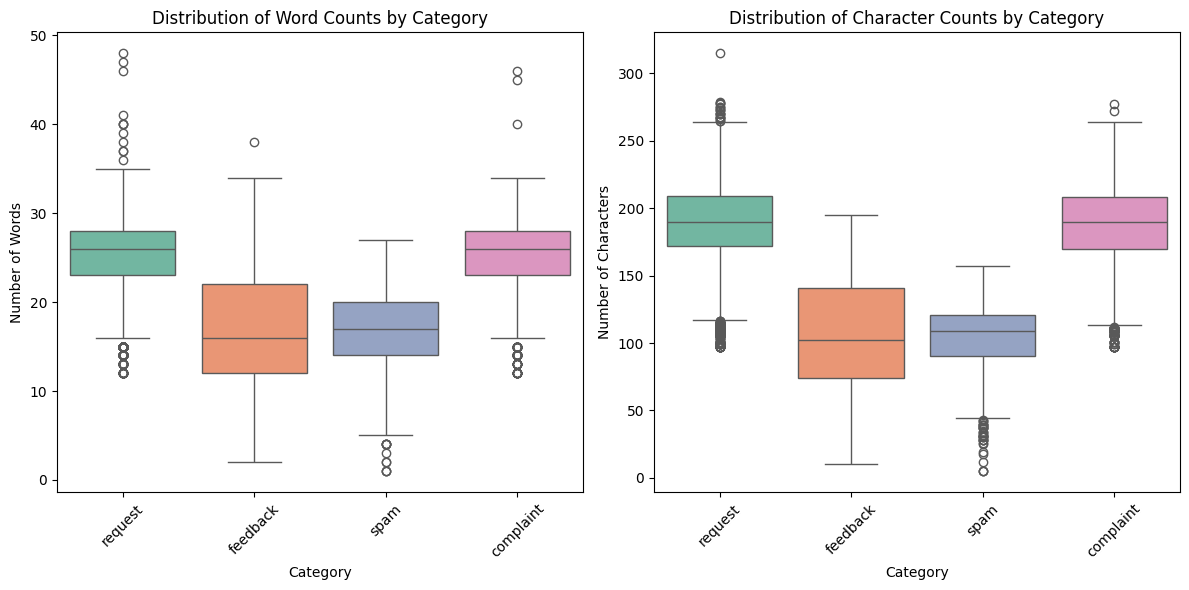

C:\Users\buddh\AppData\Local\Temp\ipykernel_23880\4063763094.py:207: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='num_words', data=df_final[df_final['num_words'] < 500], palette='Set2')


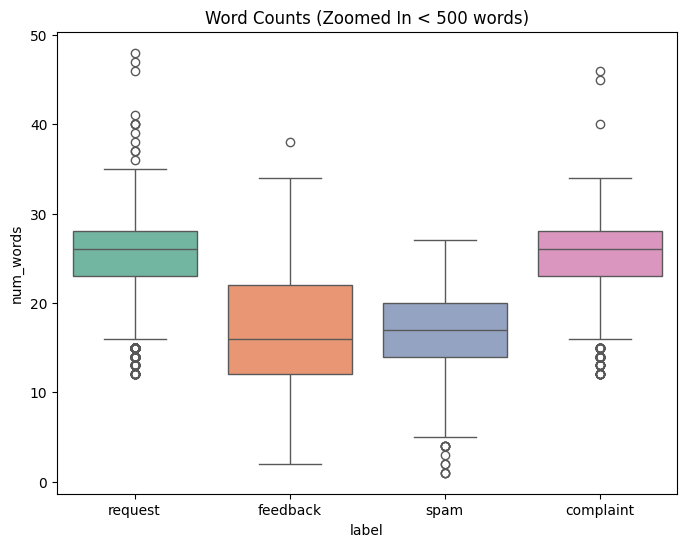


SAVING FINAL DATASET
Dataset successfully saved to 'final_processed_data.csv'
                                                text  category urgency  \
0  I'm having an issue with the {product_purchase...   request    high   
1  I'm unable to access my {product_purchased} ac...   request  medium   
2  ive been playing this for a few months, I have...  feedback     low   
3  Shop till u Drop, IS IT YOU, either 10K, 5K, £...      spam     low   
4  I luv this app! it is the best app ever! it is...  feedback     low   

                                        Cleaned_Text     label  \
0  im issue productpurchased please assist added ...   request   
1  im unable access productpurchased account keep...   request   
2  ive playing month best weapon armor get fun ad...  feedback   
3  shop till u drop either 10k 5k £500 cash £100 ...      spam   
4  luv app best app ever appropriate truth dare g...  feedback   

   num_characters  num_words  num_sentences  
0             199         27     

In [1]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_email(text):
    text = str(text).lower()
    text = re.sub(r'\S+@\S+', "", text) 
    text = re.sub(r"http\S+|www\S+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    words = text.split()
    processed_words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return " ".join(processed_words)

# LOAD DATASETS

df_support = pd.read_csv('customer_support_tickets.csv')
df_spam = pd.read_csv('mail_data.csv')
df_feedback = pd.read_csv('amazon.csv')

# PREPARE SUPPORT DATA (Splitting into Complaints & Requests)

df_support['text'] = df_support['Ticket Description']
df_support['category'] = df_support['Ticket Type'].map({ 
    'Technical issue': 'complaint', 
    'Billing inquiry': 'request', 
    'Product inquiry': 'request', 
    'Cancellation request': 'request', 
    'Refund request': 'request' })

df_support['urgency'] = df_support['Ticket Priority'].map({ 'Critical': 'high', 'High': 'high', 'Medium': 'medium', 'Low': 'low' })
df_support = df_support[['text', 'category', 'urgency']].dropna()

df_support['Cleaned_Text'] = df_support['text'].apply(clean_email)


# 1. PROCESS & PRINT COMPLAINTS

print("\n" + "="*50)
print("PROCESSING COMPLAINTS DATA")
print("="*50)

df_complaints = df_support[df_support['category'] == 'complaint']
print(f"Total Complaints: {len(df_complaints)}")
print(df_complaints[['urgency', 'text', 'Cleaned_Text']].head())



# 2. PROCESS & PRINT REQUESTS

print("\n" + "="*50)
print("PROCESSING REQUESTS DATA")
print("="*50)

df_requests = df_support[df_support['category'] == 'request']
print(f"Total Requests: {len(df_requests)}")
print(df_requests[['urgency', 'text', 'Cleaned_Text']].head())


# 3. PROCESS & PRINT SPAM DATA 

print("\n" + "="*50)
print("PROCESSING SPAM DATA")
print("="*50)

df_spam = df_spam[df_spam['Category'] == 'spam']
df_spam['text'] = df_spam['Message']
df_spam['category'] = 'spam'
df_spam['urgency'] = 'low'
df_spam = df_spam[['text', 'category', 'urgency']]

print("Cleaning Spam Data...")
df_spam['Cleaned_Text'] = df_spam['text'].apply(clean_email)
print(df_spam[['urgency', 'text', 'Cleaned_Text']].head())


#  4. PROCESS & PRINT FEEDBACK DATA 

print("\n" + "="*50)
print("PROCESSING FEEDBACK DATA")
print("="*50)

df_feedback = df_feedback[df_feedback['label'] == 1]
df_feedback['text'] = df_feedback['Text']
df_feedback['category'] = 'feedback'
df_feedback['urgency'] = 'low'
df_feedback = df_feedback[['text', 'category', 'urgency']]
df_feedback = df_feedback.sample(n=min(2000, len(df_feedback)), random_state= 42 )

print("Cleaning Feedback Data...")
df_feedback['Cleaned_Text'] = df_feedback['text'].apply(clean_email)
print(df_feedback[['urgency', 'text', 'Cleaned_Text']].head())


# 5. MERGE & TRAIN

print("\n" + "="*50)
print("MERGING AND TRAINING MODEL")
print("="*50)

# Merge all 4 parts
df_final = pd.concat([df_complaints, df_requests, df_spam, df_feedback], ignore_index=True)
df_final = df_final.sample(frac=1).reset_index(drop=True)
df_final['Cleaned_Text'] = df_final['text'].apply(clean_email)
print(df_final[['category', 'urgency', 'text', 'Cleaned_Text']].head())

# Vectorize
vectorizer = TfidfVectorizer(max_features=5000)
x = vectorizer.fit_transform(df_final['Cleaned_Text'])

# Map Categories
y = df_final['category'].map({'spam': 0, 'complaint': 1, 'request': 2, 'feedback': 3})

# Split & Train
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state= 3 )

model = LogisticRegression(max_iter=1000)
model.fit(x_train, y_train)

# ACCURACY
print("\n" + "="*50)
print("ACCURACY")
print("="*50)

print("Accuracy : ", accuracy_score(y_test, model.predict(x_test)))


# 6. STATISTICS & VISUALIZATIONS
print("\n" + "="*50)
print("STATISTICS & VISUALIZATIONS")
print("="*50)

# Ensure label column exists
if 'Category' in df_final.columns:
    df_final['label'] = df_final['Category']
elif 'category' in df_final.columns:
    df_final['label'] = df_final['category']

# Ensure text column is string
if 'Cleaned_Message' in df_final.columns:
    text_col = 'Cleaned_Message'
elif 'Cleaned_Text' in df_final.columns:
    text_col = 'Cleaned_Text'
else:
    text_col = 'text'

print(f"Using column '{text_col}' for statistics...")
df_final[text_col] = df_final[text_col].astype(str)

# RE-CALCULATE FEATURES 
# Do this again to make sure the columns exist for the print statement
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

df_final['num_characters'] = df_final[text_col].apply(len)
df_final['num_words'] = df_final[text_col].apply(lambda x: len(x.split()))
df_final['num_sentences'] = df_final[text_col].apply(lambda x: len(nltk.sent_tokenize(x)))

# 4. PRINT STATISTICS

print("\n--- Statistics by Category ---")
print(df_final.groupby('label')[['num_characters', 'num_words', 'num_sentences']].describe())


#  PLOT BOXPLOTS

plt.figure(figsize=(12, 6))


# Plot 1: Number of Words
plt.subplot(1, 2, 1)
sns.boxplot(x='label', y='num_words', hue='label', legend=False, data=df_final, palette='Set2')
plt.title('Distribution of Word Counts by Category')
plt.xlabel('Category')
plt.ylabel('Number of Words')
plt.xticks(rotation=45)

# Plot 2: Number of Characters
plt.subplot(1, 2, 2)
sns.boxplot(x='label', y='num_characters', data=df_final, palette='Set2')
plt.title('Distribution of Character Counts by Category')
plt.xlabel('Category')
plt.ylabel('Number of Characters')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


# REMOVE OUTLIERS VISUALIZATION

plt.figure(figsize=(8, 6))
sns.boxplot(x='label', y='num_words', data=df_final[df_final['num_words'] < 500], palette='Set2')
plt.title('Word Counts (Zoomed In < 500 words)')
plt.show()


# 6. SAVING THE OUTPUT

print("\n" + "="*50)
print("SAVING FINAL DATASET")
print("="*50)

# Saving the merged, cleaned dataframe
filename = "final_processed_data.csv"
df_final.to_csv(filename, index=False)
print(f"Dataset successfully saved to '{filename}'")
print(df_final.head())






In [2]:
# ==========================================
# MILESTONE 2: EMAIL CATEGORIZATION ENGINE
# ==========================================
print("\n" + "="*50)
print("STARTING MILESTONE 2: MODEL TRAINING & EVALUATION")
print("="*50)

# Necessary Imports
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import torch
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
import numpy as np
import random

# Define target names for reports
target_names = ['spam', 'complaint', 'request', 'feedback'] 

# -------------------------------------------------------
# TASK 1: TRAIN BASELINE CLASSIFIERS
# -------------------------------------------------------

# --- A. Logistic Regression ---
print("\n--- 1. Training Logistic Regression ---")
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(x_train, y_train)

lr_pred = lr_model.predict(x_test)
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, lr_pred):.4f}")
print("Classification Report (LR):")
print(classification_report(y_test, lr_pred, target_names=target_names))

# --- B. Naive Bayes ---
print("\n--- 2. Training Naive Bayes ---")
nb_model = MultinomialNB()
nb_model.fit(x_train, y_train)

nb_pred = nb_model.predict(x_test)
print(f"Naive Bayes Accuracy: {accuracy_score(y_test, nb_pred):.4f}")
print("Classification Report (NB):")
print(classification_report(y_test, nb_pred, target_names=target_names))


# -------------------------------------------------------
# TASK 2: FINE-TUNE TRANSFORMER MODEL (DistilBERT)
# -------------------------------------------------------
print("\n--- 3. Fine-tuning DistilBERT (Transformer) ---")

# 1. Prepare Data for BERT
label_map = {'spam': 0, 'complaint': 1, 'request': 2, 'feedback': 3}

bert_texts = df_final['Cleaned_Text'].tolist()
bert_labels = df_final['category'].map(label_map).tolist()

# Split data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    bert_texts, bert_labels, test_size=0.2, random_state=3
)

# 2. Tokenization
print("Loading Tokenizer...")
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

print("Tokenizing data...")
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

# 3. Create Dataset Class
class EmailDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = EmailDataset(train_encodings, train_labels)
val_dataset = EmailDataset(val_encodings, val_labels)

# 4. Load Model
print("Loading Model...")
model_bert = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=4
)

# 5. Training Setup
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    logging_dir="./logs",
    logging_steps=10,
    eval_strategy="epoch",  
    save_strategy="no"
)

trainer = Trainer(
    model=model_bert,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

# 6. Train
print("Starting Training (Fine-tuning)...")
trainer.train()

# 7. Evaluate DistilBERT (Detailed Report)
print("\n--- DistilBERT Evaluation ---")

# Predict on the validation set
predictions = trainer.predict(val_dataset)
# Convert logits to class IDs
preds = np.argmax(predictions.predictions, axis=-1)

# Print the full Classification Report
print(f"DistilBERT Accuracy: {accuracy_score(val_labels, preds):.4f}")
print("Classification Report (DistilBERT):")
print(classification_report(val_labels, preds, target_names=target_names))


# -------------------------------------------------------
# TASK 3: PREDICTION TEST (REAL DATA)
# -------------------------------------------------------
print("\n" + "="*50)
print("PREDICTION TEST ON RANDOM DATASET SAMPLE")
print("="*50)

# 1. Pick a random row
random_index = random.randint(0, len(df_final) - 1)
sample_row = df_final.iloc[random_index]

input_text = sample_row['text']       
true_label = sample_row['category']   

# 2. Preprocess
cleaned_input = clean_email(input_text)

# 3. Predict with DistilBERT
inputs = tokenizer(cleaned_input, return_tensors="pt", truncation=True, padding=True, max_length=128)
inputs = {k: v.to(model_bert.device) for k, v in inputs.items()}

with torch.no_grad():
    outputs = model_bert(**inputs)

predicted_class_id = torch.argmax(outputs.logits, dim=1).item()
reverse_label_map = {v: k for k, v in label_map.items()}
predicted_result = reverse_label_map[predicted_class_id]

# 4. Display Results
print(f"Input Email :\n'{input_text}'\n")
print(f"Predicted Label : {predicted_result.upper()}")
print(f"Actual Label : {true_label.upper()}")

if true_label == predicted_result:
    print("\n Result: ACCURATE")
else:
    print("\n Result: INCORRECT")


STARTING MILESTONE 2: MODEL TRAINING & EVALUATION


C:\Users\buddh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



--- 1. Training Logistic Regression ---
Logistic Regression Accuracy: 0.8396
Classification Report (LR):
              precision    recall  f1-score   support

        spam       1.00      0.91      0.95       150
   complaint       0.50      0.01      0.01       347
     request       0.80      1.00      0.89      1363
    feedback       0.97      1.00      0.98       384

    accuracy                           0.84      2244
   macro avg       0.82      0.73      0.71      2244
weighted avg       0.79      0.84      0.77      2244


--- 2. Training Naive Bayes ---
Naive Bayes Accuracy: 0.8347
Classification Report (NB):
              precision    recall  f1-score   support

        spam       1.00      0.89      0.94       150
   complaint       0.00      0.00      0.00       347
     request       0.79      1.00      0.88      1363
    feedback       0.99      0.98      0.98       384

    accuracy                           0.83      2244
   macro avg       0.69      0.72      0.70

C:\Users\buddh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\buddh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\buddh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_clas

Tokenizing data...
Loading Model...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting Training (Fine-tuning)...


C:\Users\buddh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss
1,0.405200,0.398719
2,0.327900,0.396394



--- DistilBERT Evaluation ---


DistilBERT Accuracy: 0.8431
Classification Report (DistilBERT):
              precision    recall  f1-score   support

        spam       1.00      0.97      0.98       150
   complaint       0.00      0.00      0.00       347
     request       0.80      1.00      0.89      1363
    feedback       0.99      1.00      0.99       384

    accuracy                           0.84      2244
   macro avg       0.70      0.74      0.72      2244
weighted avg       0.72      0.84      0.77      2244


PREDICTION TEST ON RANDOM DATASET SAMPLE


C:\Users\buddh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\buddh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\buddh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_clas

Input Email :
'I'm having an issue with the {product_purchased}. Please assist.

How do we find out which is the right product for you?

To find out which is the right product, just click on the link below. I rely heavily on my {product_purchased} for my daily tasks, and this issue is hindering my productivity.'

Predicted Label : REQUEST
Actual Label : REQUEST

 Result: ACCURATE
